# Mini-Projet :  Détection de sons de Beatbox

## Nom du binôme : Oleg PAILLOT

L'objectif de ce TP consiste à détecter et reconnaître les différents sons de beatbox à partir de fichiers sonores au format *.wav* via l'analyse cepstrale.


<img src="./Sons_Beatbox.png" width="800">



Vous disposez d'une base d'enregistrements de beatbox. Il faut reconnaître les 12 sons beatbox suivants :

$$\text{'cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming', }$$
$$\text{'kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse'}$$


**Source :** https://pubs.aip.org/asa/jasa/article/149/1/191/610401 \
Paroni, Annalisa, et al. *Vocal drum sounds in human beatboxing: An acoustic and articulatory exploration using electromagnetic articulography.* The Journal of the Acoustical Society of America 149.1 (2021): 191-206.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Chargement des données 


Le fichier source sur lequel vous travaillez est la conversion des enregistrements audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

La matrice de données est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 13.

In [2]:
# Chargement des données à partir d'un fichier matlab .mat
import scipy.io as sio
test = sio.loadmat('2016HBXX_effets_mfcc_nodeltas_XY_nozcaPerFile_zcaX.mat')


# data = matrice des données : nombre d'enregistrements x 13 coefficients
data=test['X']
data=np.array(data)
data=data.astype('float64')
print('Dimension de la matrice des MFCC :',data.shape)

# label = Numéro correspondant à un son de beatbox associé à chaque enregistrement
label=test['Y']
label=np.ravel(label)
print('Dimension des labels', label.shape)

# liste des sons de beatbox
Nomlabel=['cymbale_expiree', 'cymbale_inspiree', 'hihat_humming', 'hihat_power ferme', 'hihat_power ouvert', 'kick_humming','kick_power','rimshot_humming', 'rimshot_power', 'snare_humming', 'snare_power', 'snare_power inverse']



Dimension de la matrice des MFCC : (341, 13)
Dimension des labels (341,)


In [3]:
# Description du jeu de données 
unique, counts = np.unique(label, return_counts=True)


for i in range(unique.shape[0]):
    print('Label',unique[i],'correspond à ',Nomlabel[i],':',counts[i],'enregistrements');

Label 0 correspond à  cymbale_expiree : 28 enregistrements
Label 1 correspond à  cymbale_inspiree : 18 enregistrements
Label 2 correspond à  hihat_humming : 37 enregistrements
Label 3 correspond à  hihat_power ferme : 20 enregistrements
Label 4 correspond à  hihat_power ouvert : 24 enregistrements
Label 5 correspond à  kick_humming : 37 enregistrements
Label 6 correspond à  kick_power : 42 enregistrements
Label 7 correspond à  rimshot_humming : 25 enregistrements
Label 8 correspond à  rimshot_power : 38 enregistrements
Label 9 correspond à  snare_humming : 30 enregistrements
Label 10 correspond à  snare_power : 22 enregistrements
Label 11 correspond à  snare_power inverse : 20 enregistrements


###  Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisée. 

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [5]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


# Partie I : Classification des sons beatbox sans prétraitement 

Réaliser une classification de ces sons de beatbox par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser l'image des signaux présenté ci-dessus pour interpréter les résultats.

## Méthode supervisée  : 
indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

## KNN avec k=3

In [6]:
# A compléter
from sklearn.neighbors import KNeighborsClassifier

On test le model avec plusieurs valeur de k

In [7]:
models = []
for k in range(1, 9):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score = round(knn.score(X_test, y_test), 3)  # pour garder 3 chifre significatif apres virgule
    models.append(score)

print(models)

[0.938, 0.947, 0.956, 0.956, 0.956, 0.947, 0.947, 0.938]


On voit que notre model a plus de succes quand k = 3,4 et 5
donc on peut choisir 3 comme la valeur des voisins le plus proche à regarder

In [8]:
k=3
knn3 = KNeighborsClassifier(n_neighbors=k)
knn3.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

 ### Test de Model avec accuracy score et matrice de confusion

Le score de performance:  0.9557522123893806


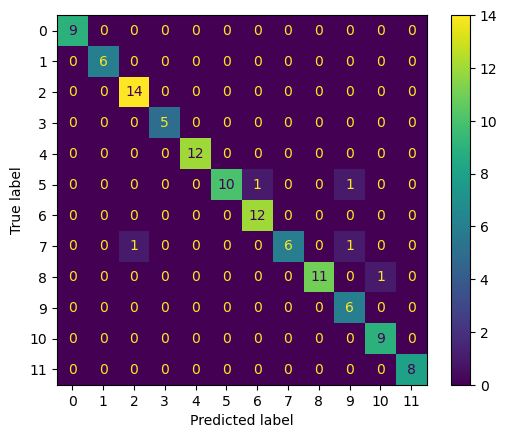

In [10]:
print("Le score de performance: ", knn3.score(X_test, y_test))

pred = knn3.predict(X_test)
cm = confusion_matrix(y_test, pred)

cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

#### Remarques
On voit que notre model marche assez bien mais on remarque qu'il a eu des problemes avec des classes n°5 n°7 et n°8

Pour classes n°5 il est mal predit une fois 6 et une fois 9

Pour classes n°7 il est mal predit une fois 2 et une fois 9

Pour classes n°8 il est mal predit une fois 6 et une fois 9

## Méthode non supervisée
Indiquer quelle est la méthode non supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score) 

# Partie II : Classification des sons beatbox avec prétraitement


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [12]:
from sklearn.decomposition import PCA

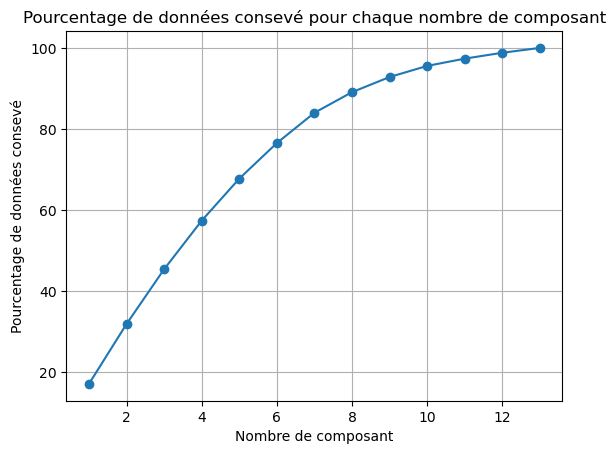

In [17]:
donne_conserves = []

for n in range(13,0,-1):
    pca = PCA(n_components=n)
    pca.fit(X_train)

    evr = pca.explained_variance_ratio_
    pourcentage_garde = sum(evr) * 100
    donne_conserves.append(pourcentage_garde)


num_components = list(range(13, 0, -1))

plt.plot(num_components, donne_conserves, marker='o')
plt.title('Pourcentage de données consevé pour chaque nombre de composant')
plt.xlabel('Nombre de composant')
plt.ylabel('Pourcentage de données consevé')
plt.grid(True)
plt.show()

#### Remarques
Comme on voit sur le schema, plus le nombre de composant diminue, plus la variance avec la data originale augmente et on perd de donées.

Donc il faut choisir une seuille où on garde plus de données possible et on reduit la dimension plus possible donc d'àpres le figure, 8 composant a l'air bien car on garde toujour 90% de donées et après il y une chute plus fort.

## PCA avec 8 componenets et  KNN avec k=3

In [13]:
acp = PCA(n_components=8)
X_train_pca = acp.fit_transform(X_train)
X_test_pca = acp.transform(X_test)

k=3
knnPCA = KNeighborsClassifier(n_neighbors=k)
knnPCA.fit(X_train_pca, y_train)


KNeighborsClassifier(n_neighbors=3)

Accuracy score:  0.9203539823008849


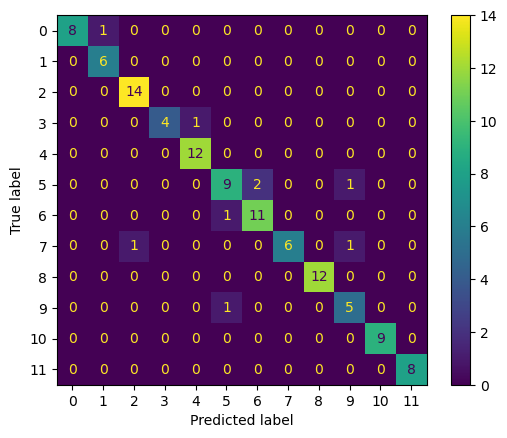

In [21]:
print("Accuracy score: ", knnPCA.score(X_test_pca, y_test))

pred = knnPCA.predict(X_test_pca)
cm = confusion_matrix(y_test, pred)

cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

Après la prédiction, on voit que notre model marche assez bien avec 8 dimension mais on a quand meme perdu de performance par rapport à la model précedent. 

Et aussi les individus mal predit avec notre model sans reduction de dimension, ils sont mal predit cette fois-ci aussi.

Donc on peut dire que quand on a une très grand données a traiter, c'est une perte que nous pouvons permettre.


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données 

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

# Partie III : Votre analyse


Pour chaque résultat obtenu, calculer la matrice de confusion et utiliser l'article et les signaux présentés ci-dessus pour interpréter les résultats.

Un rapport de maximum 10 pages sera à rendre avec le notebook des codes ayant donné ces résultats.

On dispose de données de 341 enregistrements de beatbox différents, répartis en 12 catégories distinctes. Après une prétraitement d'analyse fréquentielle, nous avons extrait 13 caractéristiques permettant de classifier les sons à l'aide du modèle que nous avons construit. Ensuite, nous avons divisé nos données en un ensemble d'entraînement (228 enregistrements) et un ensemble de test (113 enregistrements).

Pour la partie supervisée, nous avons opté pour l'algorithme KNN avec k=3, et nous avons constaté qu'il a donné des résultats assez satisfaisants sur notre jeu de test, avec une précision de 96%. Sur les 113 enregistrements de test, il s'est trompé seulement pour 5 individus, qui appartiennent aux classes 5, 7 et 8.

Ensuite, afin de réduire la dimension de nos données, nous avons utilisé l'algorithme PCA pour projeter nos données dans un espace de 8 dimensions. Nous avons ensuite réappliqué notre algorithme KNN avec k=3, obtenant cette fois-ci un score de précision de 92%. Dans la matrice de confusion, nous avons observé que les erreurs se sont produites principalement pour les classes 5 et 7, mais pas plus pour la classe 8.